In [1]:
import os


import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import cv2

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score





# Define dataset path
dataset_path = "/kaggle/input/facial-expression-recognization/train"  # Replace with your dataset path

# Define emotion labels and their corresponding numerical values
emotions = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

# Image parameters
IMG_SIZE = 48
BATCH_SIZE = 80

# Function to load and preprocess images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  # Use .jpg images and convert to grayscale
    image = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))  # Resize image
    image = image / 255.0  # Normalize to [0,1]
    return image, label

# Collect image paths and labels using Python lists
image_paths = []
labels = []

for emotion, label in emotions.items():
    folder_path = os.path.join(dataset_path, emotion)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg"):
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(label)

# Convert lists to NumPy arrays before splitting
image_paths = np.array(image_paths)
labels = np.array(labels)

# Split dataset: 80% training, 20% testing
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)


# Convert the splits to TensorFlow tensors (if desired)
train_paths = tf.constant(train_paths)
train_labels = tf.constant(train_labels, dtype=tf.int32)
test_paths = tf.constant(test_paths)
test_labels = tf.constant(test_labels, dtype=tf.int32)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Apply preprocessing, batching, and prefetching
train_dataset = train_dataset.shuffle(len(train_paths)) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

print("Datasets created successfully!")


Datasets created successfully!


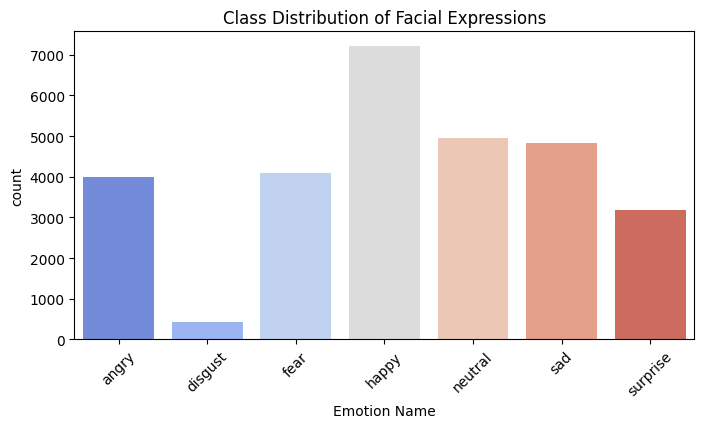

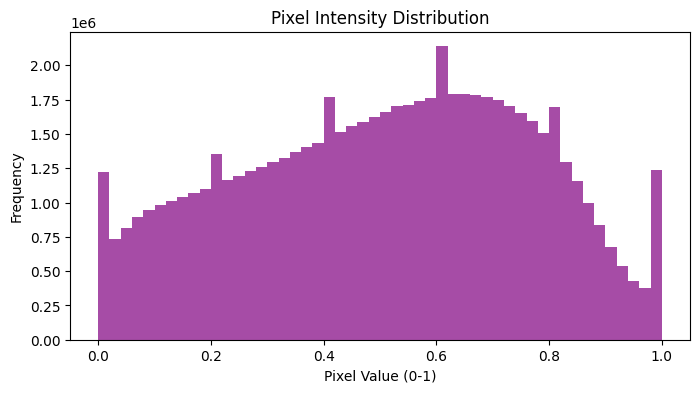

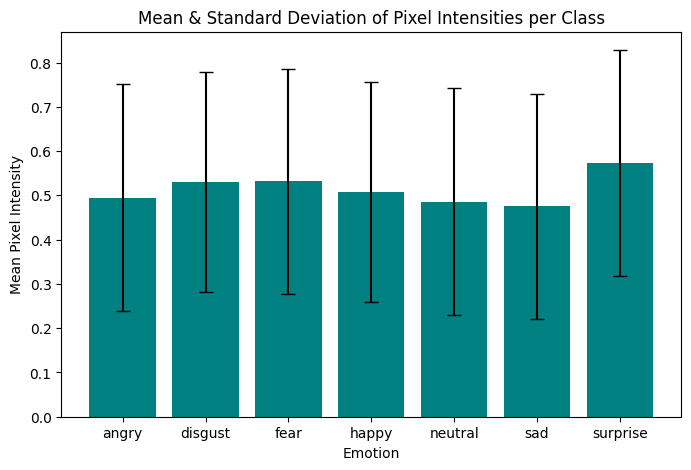

In [2]:

X, y = [], []

for expression, label in emotions.items():
    folder_path = os.path.join(dataset_path, expression)  # Path to expression folder
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} does not exist. Skipping...")
        continue

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is None:
            continue  # Skip if image is unreadable

        img = cv2.resize(img, (48, 48))  # Resize to 48x48
        X.append(img)
        y.append(label)

# Convert lists to NumPy arrays
X = np.array(X, dtype="float32") / 255.0  # Normalize pixel values (0-1)
X = X.reshape(-1, 48, 48, 1)  # Reshape for CNN input
y = np.array(y)


y = to_categorical(y, num_classes=7)

# Step 4: Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_labels = np.argmax(y, axis=1)



df = pd.DataFrame({"Emotion": y_labels})
df["Emotion Name"] = df["Emotion"].map({v: k for k, v in emotions.items()})

# 2️⃣ Plot class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion Name", data=df, palette="coolwarm", order=emotions.keys())
plt.title("Class Distribution of Facial Expressions")
plt.xticks(rotation=45)
plt.show()



# 4️⃣ Check pixel intensity distribution
plt.figure(figsize=(8, 4))
plt.hist(X.flatten(), bins=50, color="purple", alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (0-1)")
plt.ylabel("Frequency")
plt.show()



means = [np.mean(X[y_labels == i]) for i in range(7)]
stds = [np.std(X[y_labels == i]) for i in range(7)]

# Plot mean pixel values per class
plt.figure(figsize=(8, 5))
plt.bar(emotions.keys(), means, yerr=stds, capsize=5, color="teal")
plt.xlabel("Emotion")
plt.ylabel("Mean Pixel Intensity")
plt.title("Mean & Standard Deviation of Pixel Intensities per Class")
plt.show()

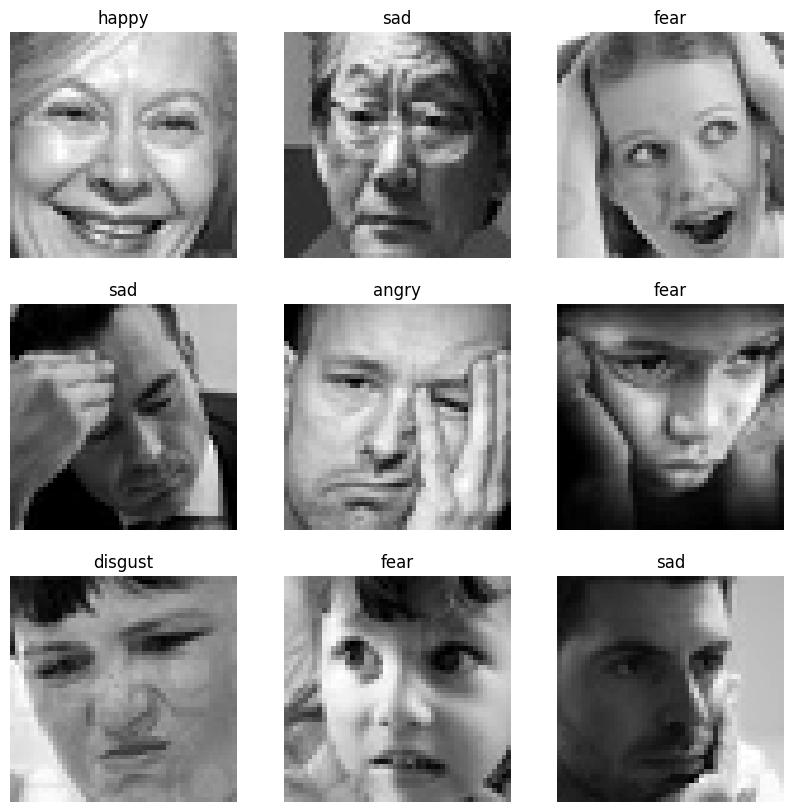

In [3]:
emotions_reverse = {v: k for k, v in emotions.items()}


def display_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")  # Display image
            plt.title(emotions_reverse[labels[i].numpy()])  # Convert label to text
            plt.axis("off")
    
    plt.show()

# Display some images
display_images(train_dataset)

In [4]:


IMG_SIZE = (48, 48, 1)  # Grayscale images

def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save input for residual connection

    # First 1x1 Conv layer (Bottleneck - reduce dimensions)
    x = layers.Conv2D(filters // 4, (1, 1), strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Main 3x3 Conv layer
    x = layers.Conv2D(filters // 4, (kernel_size, kernel_size), strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Last 1x1 Conv layer (Restore dimensions)
    x = layers.Conv2D(filters, (1, 1), strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # If input and output dimensions are different, apply a 1x1 Conv to match dimensions
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add Residual Connection
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x
def build_resnet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, (3,3), strides=1, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)

    # ResNet Blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, stride=2)  # Downsample
    x = resnet_block(x, 256, stride=2)  # Downsample
    x = resnet_block(x, 512, stride=2)  # Downsample

    # Global Average Pooling & Fully Connected Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model


def build_cnn():
    model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(7, activation='softmax')  # 7 classes
    ])
    return model


# Create Model
model = build_resnet(input_shape=(48, 48, 1), num_classes=7)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 48, 48, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 48, 48, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 48, 48, 16)     │          1,040 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 48, 48, 16)     │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 48, 48, 16)     │          2,320 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 48, 48, 16)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 48, 48, 64)     │          1,088 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 48, 48, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 48, 48, 64)     │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 48, 48, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 24, 24, 32)     │          2,080 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 24, 24, 32)     │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 24, 24, 32)     │          9,248 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 24, 24, 32)     │            128 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 24, 24, 128)    │          4,224 │ batch_normalization_5… │
├──────────────────────

 Total params: 644,647 (2.46 MB)

 Trainable params: 639,847 (2.44 MB)

 Non-trainable params: 4,800 (18.75 KB)

In [5]:
# Constants
IMG_SIZE = 48  # Input image size
PATCH_SIZE = 6  # Size of each patch (Splitting 48x48 into 8x8 patches)
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  # Number of patches
D_MODEL = 64  # Embedding dimension
NUM_HEADS = 4  # Multi-head attention
NUM_LAYERS = 4  # Transformer layers
MLP_DIM = 128  # Feedforward network size
DROPOUT_RATE = 0.1  # Dropout
NUM_CLASSES = 7  # Facial expression classes

class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.d_model = d_model
        self.projection = layers.Dense(d_model)  # Linear projection for each patch
        self.position_embedding = None  # Initialize as None (will be built later)

    def build(self, input_shape):
        # Dynamically determine the number of patches from input shape
        height, width = input_shape[1], input_shape[2]
        num_patches = (height // self.patch_size) * (width // self.patch_size)

        # Create the position embedding weight
        self.position_embedding = self.add_weight(
            name="pos_embed",
            shape=(1, num_patches, self.d_model),  # (1, num_patches, d_model)
            initializer="zeros",
            trainable=True
        )

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )  
        patches = tf.reshape(patches, [batch_size, -1, tf.shape(patches)[-1]])  # Auto-calculate NUM_PATCHES
        x = self.projection(patches)  # Linear projection to d_model

        # Broadcast position embeddings across batch size
        pos_embed = tf.broadcast_to(self.position_embedding, [batch_size, tf.shape(x)[1], self.d_model])
        
        return pos_embed




# 2. Transformer Encoder Block
def transformer_encoder(x, num_heads, d_model, mlp_dim, dropout_rate):
    # Multi-Head Self Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    x = layers.LayerNormalization()(x + attn_output)  # Add & Norm

    # Feedforward Network (MLP)
    mlp_output = layers.Dense(mlp_dim, activation="relu")(x)
    mlp_output = layers.Dense(d_model)(mlp_output)
    mlp_output = layers.Dropout(dropout_rate)(mlp_output)
    x = layers.LayerNormalization()(x + mlp_output)  # Add & Norm

    return x

# 3. Build the ViT Model
def build_vit(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = PatchEmbedding(PATCH_SIZE, D_MODEL)(inputs)  # Convert image to patches

    # Transformer Encoder Stack
    for _ in range(NUM_LAYERS):
        x = transformer_encoder(x, NUM_HEADS, D_MODEL, MLP_DIM, DROPOUT_RATE)

    # Classification Head
    x = layers.GlobalAveragePooling1D()(x)  # Reduce sequence to a single vector
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.Dense(MLP_DIM, activation="relu")(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Create Model
# model = build_vit(input_shape=(IMG_SIZE, IMG_SIZE, 1))



In [6]:
# Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train Model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100
)


Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - accuracy: 0.2289 - loss: 1.9775 - val_accuracy: 0.2518 - val_loss: 1.8088
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.2671 - loss: 1.7690 - val_accuracy: 0.2990 - val_loss: 1.8074
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3304 - loss: 1.6587 - val_accuracy: 0.3269 - val_loss: 1.7111
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.3707 - loss: 1.5832 - val_accuracy: 0.3718 - val_loss: 1.6052
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.3970 - loss: 1.5261 - val_accuracy: 0.3788 - val_loss: 1.6346
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4214 - loss: 1.4747 - val_accuracy: 0.4289 - val_loss: 1.4459
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.4237 - loss: 1.4493 - val_accuracy: 0.4253 - val_loss: 1.5054
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.4429 - loss: 1.4245 -

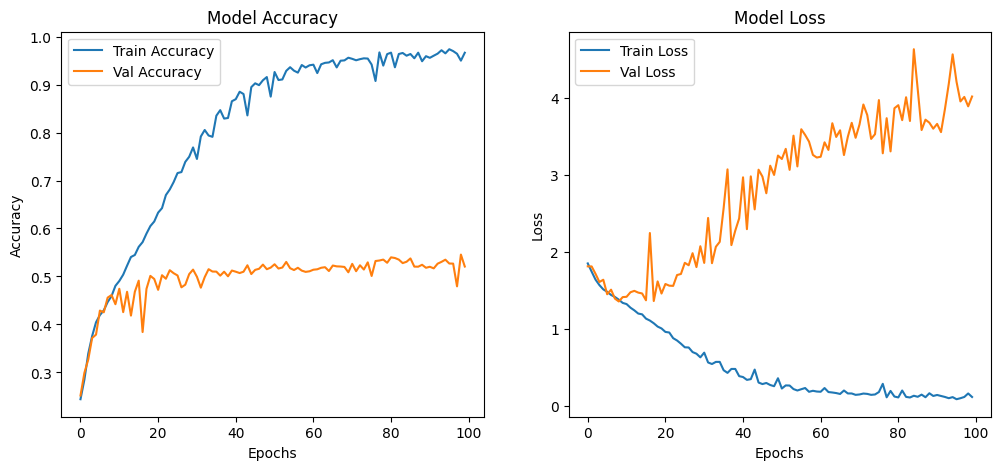

In [7]:
# Plot accuracy & loss curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 865ms/step


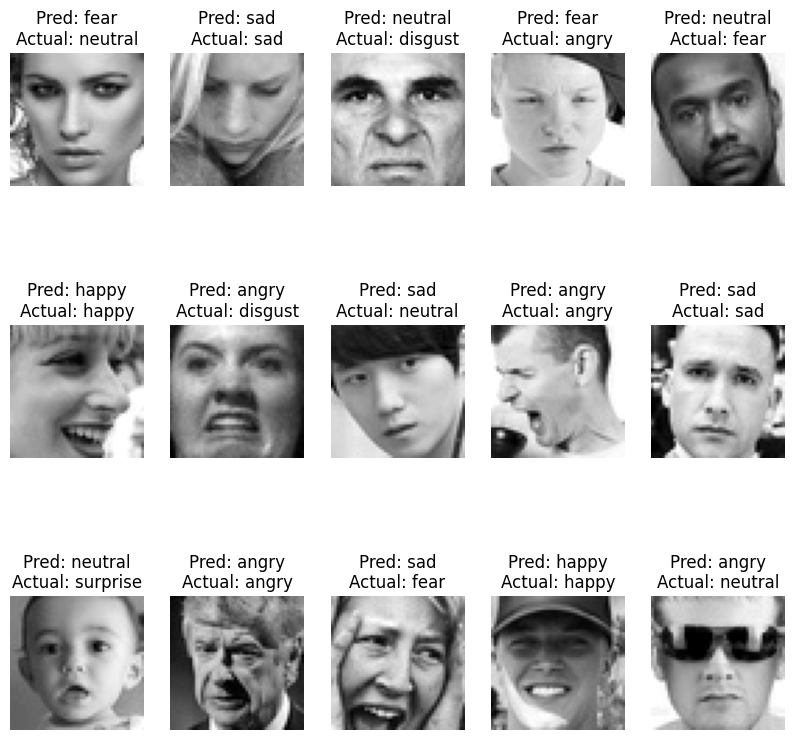

In [8]:

def display_predictions(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    
    class_names = list(emotions.keys())
    
    for images, labels in dataset.take(1):  # Take one batch
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)
        
        for i in range(num_images):
            plt.subplot(3, 5, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")  # Display image
            plt.title(f"Pred: {class_names[predicted_labels[i]]}\nActual: {class_names[labels[i].numpy()]}")
            plt.axis("off")
    
    plt.show()

# Display some test images with predictions
display_predictions(test_dataset,15)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
Precision: 0.5214
Recall: 0.5207
F1-Score: 0.5144


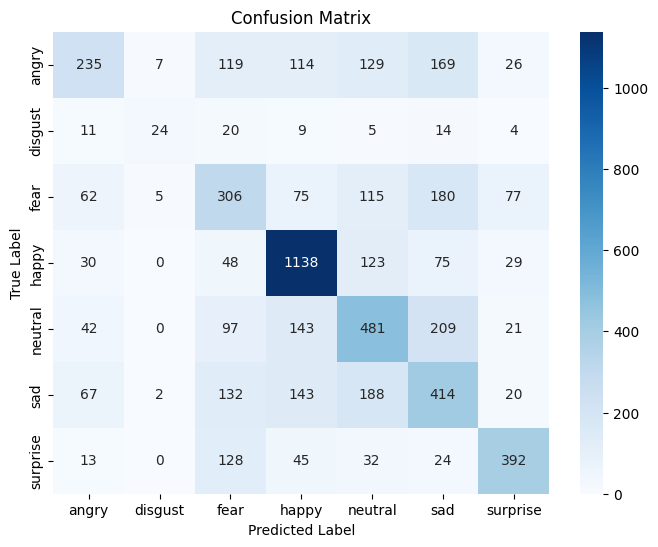

In [9]:
# Get model predictions
y_pred_prob = model.predict(test_dataset)  # Probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class labels



# Get actual labels from test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)




precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotions.keys(), yticklabels=emotions.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [11]:
# Save model weights
model.save_weights("facial_expression.weights.h5")
